O problema da eliminação de beisebol consiste em determinar quais equipes em uma liga estão "matematicamente eliminadas" de terminar a temporada em primeiro lugar, ou empatadas em primeiro lugar. Este é um problema clássico, popularizado pela primeira vez por Alan Hoffman na década de 1960, e é uma aplicação padrão de técnicas de otimização e fluxo máximo em redes.

Dados de Entrada

A entrada geralmente consiste em:
- O número de equipes, n.
- Para cada equipe i, wi (ou W[i]) representa o número de vitórias já conquistadas.
- Para cada par de equipes i e j, gij (ou G[i, j] ou rij) representa o número de jogos restantes a serem disputados entre elas.
- O total de jogos restantes para a equipe i pode ser denotado como ri (ou R[i]), que é a soma de gij para todos os j.

O que significa "Eliminada"?

Uma equipe k é considerada eliminada se não puder, de forma alguma, terminar a temporada em primeiro lugar, ou empatada em primeiro lugar, considerando qualquer resultado possível dos jogos restantes. Assume-se que nenhum jogo termina em empate e que todos os jogos restantes são disputados.

Eliminação Simples vs. Complexa

Frequentemente, a eliminação de uma equipe pode parecer óbvia para um comentarista esportivo ingênuo. Essa razão "simples" para a eliminação ocorre se uma equipe i não conseguir vencer jogos suficientes para alcançar o líder atual j. Ou seja, se wi + ri < wj para alguma outra equipe j, então a equipe i está certamente eliminada. Por exemplo, se Montreal pode terminar com no máximo 80 vitórias, mas Atlanta já tem 83 vitórias, Montreal é eliminada.

No entanto, essa condição é suficiente, mas não necessária. A complexidade do problema surge porque a resposta depende não apenas do número de jogos ganhos e a serem jogados, mas também da programação específica dos jogos restantes (quem joga contra quem). Uma equipe pode parecer ter uma chance com base em suas vitórias máximas possíveis, mas ainda assim ser eliminada devido à forma como outras equipes devem jogar entre si.

Por exemplo, considere um cenário em que Detroit poderia terminar com 49 + 27 = 76 vitórias. Mesmo que eles vençam todos os jogos restantes, eles podem ser eliminados devido aos jogos disputados entre as outras equipes líderes. Filadélfia, por exemplo, pode ser eliminada mesmo que possa atingir 83 vitórias, porque outras equipes como Atlanta ou Nova York têm a garantia de terminar com um número maior de vitórias com base em seus jogos inter-divissionais. O número total de vitórias entre um subconjunto de equipes (digamos, R) e os jogos restantes entre elas (g(R)) pode implicar que pelo menos uma equipe em R deve terminar com um número médio de vitórias maior do que o que a equipe k pode alcançar. Isso é frequentemente expresso pela condição a(R) > wk + gk, onde a(R) = (w(R) + g(R)) / |R| é um limite inferior para as vitórias médias das equipes em R. Se tal subconjunto R existe, ele "elimina" a equipe k.

Condições Formais para Não-Eliminação

Mais formalmente, para uma equipe k não ser eliminada, deve haver uma atribuição de vitórias inteiras não negativas xij (onde xij é o número de jogos que a equipe i vence contra j) para todos os jogos restantes, de modo que:

- Todos os jogos restantes sejam disputados: x<sub>ij</sub> + x<sub>ji</sub> = g<sub>ij</sub> = g<sub>ji</sub> para todo i, j.
- Nenhuma equipe termine com mais vitórias do que a equipe k: w<sub>k</sub> + ∑j∈T x<sub>kj</sub> ≥ w<sub>i</sub> + ∑j∈T x<sub>ij</sub> para todo j.
Essa natureza intrincada do problema, particularmente a presença de "razões mais complicadas" para a eliminação, torna-o adequado para análise usando algoritmos de fluxo máximo.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt



In [ ]:
def create_baseball_elimination_graph(games_left_between_others, team_to_sink_capacities):
    """
    Cria o grafo de fluxo para o problema de eliminação de beisebol,
    utilizando a formulação de Schwartz/Gusfield-Martel.

    Parâmetros:
    - games_left_between_others (dict): Dicionário onde as chaves são tuplas (time1, time2)
                                       e os valores são o número de jogos restantes entre eles.
                                       Estas se tornam as capacidades das arestas de 's' para os nós de jogo.
    - team_to_sink_capacities (dict): Dicionário onde as chaves são os nomes das equipes competidoras
                                      e os valores são as capacidades das arestas dessas equipes para o sumidouro 't'.

    Retorna:
    - G (nx.DiGraph): O grafo de fluxo construído.
    """
    G = nx.DiGraph()
    source = 's'
    sink = 't'

    # Adiciona arestas da fonte (s) para os nós de jogo (game_ij)
    # A capacidade é o número de jogos restantes entre os dois times
    for (team1, team2), games in games_left_between_others.items():
        game_node = f"game_{team1}_{team2}" # Nome único para o nó do jogo
        G.add_edge(source, game_node, capacity=games)

    # Adiciona arestas dos nós de jogo para os nós das equipes envolvidas
    # A capacidade é infinita, permitindo que os jogos sejam "atribuídos" livremente
    unique_teams_in_games = set() # Para garantir que os nós de equipe existam antes de ligar ao sumidouro
    for (team1, team2), _ in games_left_between_others.items():
        game_node = f"game_{team1}_{team2}"
        G.add_edge(game_node, team1, capacity=float('inf'))
        G.add_edge(game_node, team2, capacity=float('inf'))
        unique_teams_in_games.add(team1)
        unique_teams_in_games.add(team2)

    # Adiciona arestas dos nós de equipe para o sumidouro (t)
    # A capacidade é o máximo de vitórias que a equipe pode ter sem exceder o limite da equipe alvo
    for team, capacity in team_to_sink_capacities.items():
        # Assegura que o nó da equipe existe, mesmo que não esteja envolvido em jogos entre "outras" equipes
        if team not in G:
            G.add_node(team)
        G.add_edge(team, sink, capacity=capacity)

    return G



In [6]:
def check_baseball_elimination(G, source, sink):
    """
    Verifica a eliminação de beisebol para uma equipe alvo.

    Parâmetros:
    - G (nx.DiGraph): O grafo de fluxo.
    - source (str): Nome do nó fonte.
    - sink (str): Nome do nó sumidouro.

    Retorna:
    - Uma tupla: (is_eliminated, max_flow_value, total_s_capacity, S_partition, T_partition)
      - is_eliminated (bool): True se a equipe alvo estiver eliminada, False caso contrário.
      - max_flow_value (float): O valor do fluxo máximo encontrado na rede.
      - total_s_capacity (float): A soma das capacidades das arestas que saem da fonte 's'.
      - S_partition (set): O conjunto de nós no lado da fonte da min-corte.
      - T_partition (set): O conjunto de nós no lado do sumidouro da min-corte.
    """
    # Calcula o fluxo máximo e a min-corte usando o algoritmo de Edmonds-Karp
    max_flow_value, partition = nx.minimum_cut(G, source, sink)
    S_partition, T_partition = partition

    # Calcula a capacidade total das arestas que saem da fonte
    total_s_capacity = sum(G[source][node]['capacity'] for node in G.successors(source))

    # A equipe é eliminada se o fluxo máximo for menor que a capacidade total de saída da fonte
    is_eliminated = max_flow_value < total_s_capacity

    return is_eliminated, max_flow_value, total_s_capacity, S_partition, T_partition



In [7]:
def draw_flow_graph(G, S_partition=None, T_partition=None, title="Grafo de Fluxo/Capacidade", show_cut=False):
    """
    Desenha o grafo de fluxo/capacidade, opcionalmente destacando o corte mínimo.

    Parâmetros:
    - G (nx.DiGraph): O grafo de fluxo.
    - S_partition (set, opcional): Nós na partição S da min-corte.
    - T_partition (set, opcional): Nós na partição T da min-corte.
    - title (str): Título do gráfico.
    - show_cut (bool): Se True, destaca as partições e arestas do corte mínimo.
    """
    plt.figure(figsize=(14, 10))
    
    # Define a posição dos nós para um layout mais organizado
    pos = {}
    source = 's'
    sink = 't'
    
    # Níveis para layout hierárquico
    # Nível 0: Fonte
    pos[source] = (0, 0.5)

    # Nível 1: Nós de Jogo
    game_nodes = [node for node in G.nodes() if node.startswith('game_')]
    game_nodes.sort() # Ordenar para consistência
    num_games = len(game_nodes)
    for i, node in enumerate(game_nodes):
        pos[node] = (1, (i - (num_games - 1) / 2) * 0.2 + 0.5)

    # Nível 2: Nós de Equipe
    team_nodes = sorted([node for node in G.nodes() if node not in [source, sink] and not node.startswith('game_')])
    num_teams = len(team_nodes)
    for i, node in enumerate(team_nodes):
        pos[node] = (2, (i - (num_teams - 1) / 2) * 0.2 + 0.5)
    
    # Nível 3: Sumidouro
    pos[sink] = (3, 0.5)

    # Desenha os nós
    node_colors = []
    for node in G.nodes():
        if show_cut and S_partition and T_partition:
            if node in S_partition:
                node_colors.append('lightblue')
            elif node in T_partition:
                node_colors.append('lightcoral')
            else:
                node_colors.append('lightgray')
        else:
            if node == source:
                node_colors.append('lightgreen')
            elif node == sink:
                node_colors.append('lightsalmon')
            elif node.startswith('game_'):
                node_colors.append('lightyellow')
            else:
                node_colors.append('lightgray')

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3500, alpha=0.9, linewidths=1, edgecolors='black')
    
    # Desenha as arestas
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.7)

    # Adiciona rótulos de capacidade nas arestas
    edge_labels = nx.get_edge_attributes(G, 'capacity')
    formatted_edge_labels = { (u, v): f"{'∞' if c == float('inf') else int(c)}" for (u, v), c in edge_labels.items() }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_size=9, font_color='darkgreen')

    # Adiciona rótulos dos nós
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Destaca as arestas de corte mínimo se show_cut for True
    if show_cut and S_partition and T_partition:
        cut_edges = []
        for u, v in G.edges():
            if (u in S_partition and v in T_partition):
                cut_edges.append((u, v))
        
        nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='red', width=3, style='dashed', alpha=0.8, label='Arestas de Corte Mínimo')

    plt.title(title, size=16)
    plt.axis('off')
    plt.show()



In [8]:
# --- Dados do Exemplo do MIT (Detroit com 48 vitórias) ---
# Equipe alvo: Detroit (DET)
team_to_check_name = "Detroit"

# Vitórias (wi) e Jogos Restantes (ri) da Tabela 1 [19]
# Assumimos que Detroit ganha todos os seus jogos restantes para maximizar suas chances.
w_det = 48 # Definido pelo usuário na query
r_det = 28
W_det_max = w_det + r_det # = 48 + 28 = 76

# Vitórias atuais (wi) para as outras equipes na Tabela 1 [19]
wins_other_teams = {
    'NYY': 75,
    'BAL': 71,
    'BOS': 69,
    'TOR': 63
}

# Jogos restantes *apenas entre as equipes competidoras* (capacidades de s para nós de jogo)
# Conforme Tabela 1 de MIT6_046JS15_lec14B.pdf [19]
games_left_between_others_data = {
    ('NYY', 'BAL'): 5,
    ('NYY', 'BOS'): 7,
    ('NYY', 'TOR'): 4,
    ('BAL', 'BOS'): 2,
    ('BAL', 'TOR'): 4,
    ('BOS', 'TOR'): 4 # Importante: A tabela [19] mostra 4, enquanto a figura [15] parece omitir ou sugerir 0. Usamos a tabela para consistência.
}

# Capacidades das arestas das equipes para o sumidouro 't'
# Calculado como W_det_max - wi para cada equipe [7, 8, 11]
team_to_sink_capacities_data = {
    team: W_det_max - wins_other_teams[team] for team in wins_other_teams
}

print(f"## Análise para a Equipe Alvo: {team_to_check_name} (com {w_det} vitórias)\n")
print(f"Assumindo que {team_to_check_name} ganha todos os seus {r_det} jogos restantes, o total de vitórias possíveis para {team_to_check_name} é: {W_det_max}\n")

print("Capacidades dos jogos restantes entre as equipes competidoras (s -> nó_jogo):")
for (t1, t2), games in games_left_between_others_data.items():
    print(f"- {t1} vs {t2}: {games} jogos")

print("\nCapacidades das arestas das equipes para o sumidouro 't' (equipe -> t):")
for team, capacity in team_to_sink_capacities_data.items():
    print(f"- {team} -> t: {capacity}")

# --- Construção e Resolução do Grafo ---
print(f"\n## Construindo o grafo e executando o algoritmo para verificar a eliminação do {team_to_check_name}\n")

source_node = 's'
sink_node = 't'
G = create_baseball_elimination_graph(games_left_between_others_data, team_to_sink_capacities_data)

is_eliminated, max_flow_value, total_s_capacity, S_partition, T_partition = \
    check_baseball_elimination(G, source_node, sink_node)

# --- Apresentação dos Resultados ---
print(f"Capacidade total das arestas saindo da fonte ('s') = {total_s_capacity}")
print(f"Valor do Fluxo Máximo calculado = {max_flow_value}\n")

if is_eliminated:
    print(f"Conclusão: O {team_to_check_name} está MATEMATICAMENTE ELIMINADO [10, 15].")
    print(f"Isso ocorre porque o fluxo máximo ({max_flow_value}) é menor que a capacidade total de jogos restantes entre as outras equipes ({total_s_capacity}).")
    print("Não é possível distribuir os resultados dos jogos restantes de forma que o Detroit termine em primeiro lugar (ou empatado).")
else:
    print(f"Conclusão: O {team_to_check_name} AINDA NÃO está matematicamente eliminado.")
    print(f"Isso ocorre porque o fluxo máximo ({max_flow_value}) é igual à capacidade total de jogos restantes entre as outras equipes ({total_s_capacity}).")
    print("Existe uma forma de os jogos restantes serem jogados para que o Detroit termine em primeiro lugar (ou empatado).")




## Análise para a Equipe Alvo: Detroit (com 48 vitórias)

Assumindo que Detroit ganha todos os seus 28 jogos restantes, o total de vitórias possíveis para Detroit é: 76

Capacidades dos jogos restantes entre as equipes competidoras (s -> nó_jogo):
- NYY vs BAL: 5 jogos
- NYY vs BOS: 7 jogos
- NYY vs TOR: 4 jogos
- BAL vs BOS: 2 jogos
- BAL vs TOR: 4 jogos
- BOS vs TOR: 4 jogos

Capacidades das arestas das equipes para o sumidouro 't' (equipe -> t):
- NYY -> t: 1
- BAL -> t: 5
- BOS -> t: 7
- TOR -> t: 13

## Construindo o grafo e executando o algoritmo para verificar a eliminação do Detroit

Capacidade total das arestas saindo da fonte ('s') = 26
Valor do Fluxo Máximo calculado = 25

Conclusão: O Detroit está MATEMATICAMENTE ELIMINADO [10, 15].
Isso ocorre porque o fluxo máximo (25) é menor que a capacidade total de jogos restantes entre as outras equipes (26).
Não é possível distribuir os resultados dos jogos restantes de forma que o Detroit termine em primeiro lugar (ou empatado).



## Interpretação da Min-Corte (Certificado de Eliminação)

Valor da min-corte: 25 (igual ao fluxo máximo pelo Teorema Max-Flow Min-Cut [16])
Partição S (lado da fonte da corte): {'game_NYY_BAL', 'game_NYY_BOS', 's', 'BOS', 'game_BAL_BOS', 'NYY', 'BAL'}
Partição T (lado do sumidouro da corte): {'game_BOS_TOR', 't', 'game_BAL_TOR', 'TOR', 'game_NYY_TOR'}

O subconjunto de equipes que funciona como 'certificado de eliminação' para o Detroit é: ['BOS', 'NYY', 'BAL'].
No exemplo da fonte [15], a min-corte resulta em um fluxo máximo de 25, enquanto a capacidade total da fonte é 26.
Como 25 < 26, o Detroit está matematicamente eliminado. O conjunto que o elimina é derivado da min-corte.
Isso significa que, mesmo se Detroit vencesse todos os seus jogos restantes, essas equipes (NYY, BAL, BOS), combinadas, ainda assim o ultrapassariam.

--- Visualização do Grafo de Fluxo/Capacidade ---


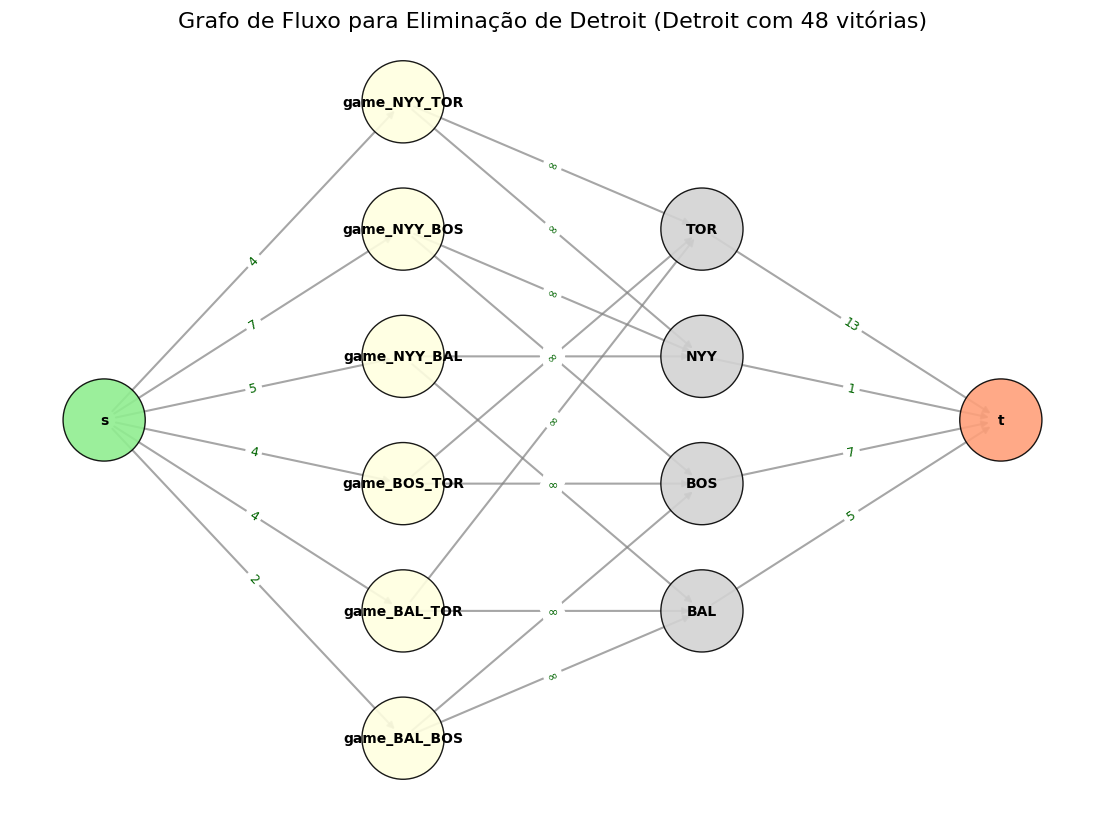


--- Visualização do Corte Mínimo ---


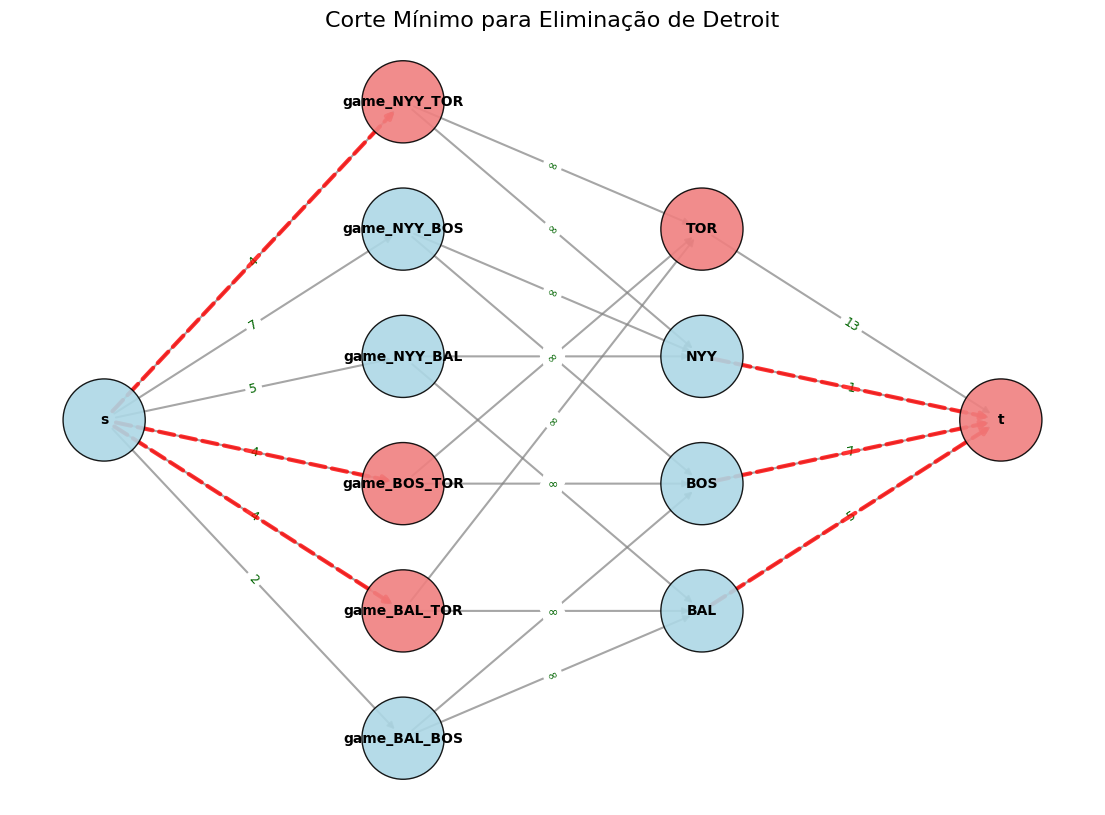

In [ ]:
# --- Interpretação da Min-Corte ---
print("\n## Interpretação da Min-Corte (Certificado de Eliminação)\n")
print(f"Valor do min-corte: {max_flow_value} (igual ao fluxo máximo pelo Teorema Max-Flow Min-Cut [16])")
print(f"Partição S (lado da fonte da corte): {S_partition}")
print(f"Partição T (lado do sumidouro da corte): {T_partition}")

# Identificar as equipes no conjunto R que eliminam (subconjunto de equipes da partição S)
other_teams_names = list(wins_other_teams.keys())
eliminating_teams = [node for node in S_partition if node in other_teams_names]

if is_eliminated:
    print(f"\nO subconjunto de equipes que funciona como 'certificado de eliminação' para o {team_to_check_name} é: {eliminating_teams}.")
    # No MIT6_046JS15_lec14B.pdf [15], a min-corte é S = {s, 1-2, 1-3, 2-3, 1, 2, 3}, onde 1=NYY, 2=BAL, 3=BOS.
    # O valor da min-corte é 25, e a capacidade total de s é 26.
    print(f"No exemplo da fonte [15], a min-corte resulta em um fluxo máximo de 25, enquanto a capacidade total da fonte é 26.")
    print(f"Como {max_flow_value} < {total_s_capacity}, o {team_to_check_name} está matematicamente eliminado. O conjunto que o elimina é derivado da min-corte.")
    print("Isso significa que, mesmo se Detroit vencesse todos os seus jogos restantes, essas equipes (NYY, BAL, BOS), combinadas, ainda assim o ultrapassariam.")
else:
    print("\nA equipe não está eliminada, então não há um subconjunto eliminador que a impeça de terminar em primeiro.")

print("\n--- Visualização do Grafo de Fluxo/Capacidade ---")
draw_flow_graph(G, title=f"Grafo de Fluxo para Eliminação de {team_to_check_name} (Detroit com {w_det} vitórias)")

print("\n--- Visualização do Corte Mínimo ---")
draw_flow_graph(G, S_partition, T_partition, title=f"Corte Mínimo para Eliminação de {team_to_check_name}", show_cut=True)
